# 4: Geocentric Models

In [362]:
%cd ~/statistical-rethinking/
import sys

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd

import torch
from pyro.distributions import Uniform, Normal

sys.path.insert(0, "/home/ecotner/statistical-rethinking/code")
from utils import HPDI

/home/ecotner/statistical-rethinking


### Code 4.1
Simulate 1000 people generating 16 numbers between -1 and 1

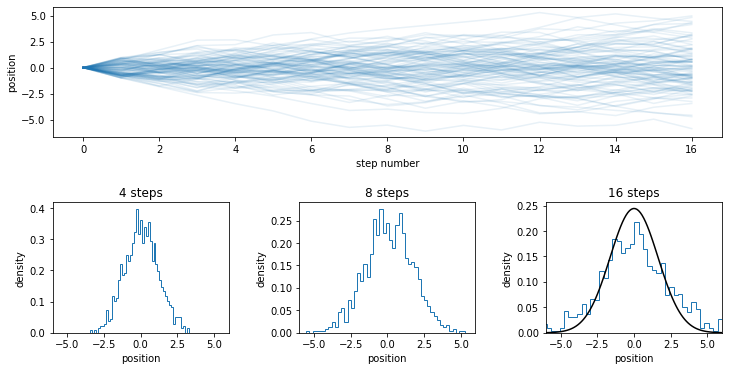

In [43]:
# Generate the numbers
x = (st.uniform.rvs(size=(1000, 16))-0.5)*2
# Make the plots
fig = plt.figure(figsize=(12, 6))
# Random walk illustration
ax1 = fig.add_subplot(211)
for steps in np.hstack([np.zeros((100, 1)), x[:100]]):
    plt.plot(np.cumsum(steps), color="C0", alpha=0.1)
ax1.set_xlabel("step number")
ax1.set_ylabel("position")
# Sequence of distributions
x = np.cumsum(x, axis=1)
for i, step in enumerate((4, 8, 16)):
    ax = fig.add_subplot(234+i)
    ax.hist(x[:,step-1], bins=50, density=True, histtype="step")
    ax.set_xlabel("position")
    ax.set_ylabel("density")
    ax.set_title(f"{step} steps")
    ax.set_xlim(left=-6, right=+6)
# Plot a gaussian approximation to the sum
var = (1/12)*(1-(-1)) # Variance of single uniform distribution
var *= 16 # Approx variance of sum of 16 iid uniforms
x = np.linspace(-6, 6, 100)
y = st.norm.pdf(x, scale=np.sqrt(var))
ax.plot(x, y, color="black")
plt.subplots_adjust(hspace=0.5, wspace=0.4)

### Code 4.2
Take the product of 12 random uniform numbers in the interval (1, 1.1)

In [145]:
np.prod(1 + 0.1*st.uniform.rvs(size=12))

1.8079947955267235

### Code 4.3
Now do the same thing 10,000 times and look at the distribution

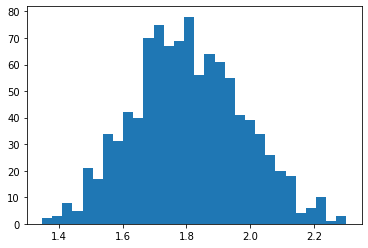

In [160]:
growth = np.prod(1 + 0.1*st.uniform.rvs(size=(1000, 12)), axis=1)
plt.hist(growth, bins=30)
plt.show()

### Code 4.4
Compare the effects of big and small multiplicative steps on convergence towards normality

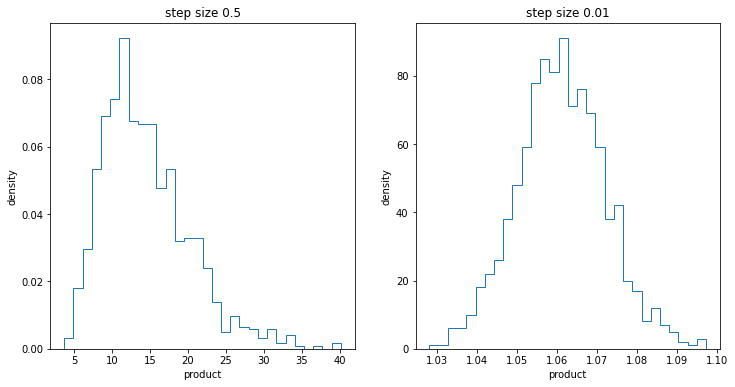

In [162]:
# Generate numbers
big = np.prod(1 + 0.5*st.uniform.rvs(size=(1000, 12)), axis=1)
small = np.prod(1 + 0.01*st.uniform.rvs(size=(1000, 12)), axis=1)
# Plot!
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
# Big
plt.sca(axes[0])
plt.hist(big, bins=30, histtype="step", density=True)
plt.xlabel("product")
plt.ylabel("density")
plt.title("step size 0.5")
# Small
plt.sca(axes[1])
plt.hist(small, bins=30, histtype="step")
plt.xlabel("product")
plt.ylabel("density")
plt.title("step size 0.01")
plt.show()

### Code 4.5
Multiplication is equivalent to addition on a log scale, i.e.
$$
\log\left(\prod_i x_i\right) = \sum_i \log(x_i)
$$

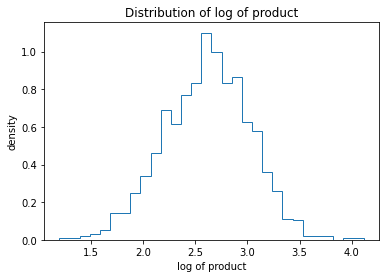

In [165]:
log_big = np.log(np.prod(1 + 0.5*st.uniform.rvs(size=(1000, 12)), axis=1))
plt.hist(log_big, bins=30, histtype="step", density=True)
plt.xlabel("log of product")
plt.ylabel("density")
plt.title("Distribution of log of product")
plt.show()

### Code 4.6
Redo the globe-tossing model for some reason?

In [168]:
w = 6; n = 9
p_grid = np.linspace(0, 1, 100)
posterior = st.binom(n=n, p=p_grid).pmf(6) * st.uniform.pdf(p_grid)
posterior /= posterior.sum()

### Code 4.7/4.8/4.9/4.10
Load some data on foraging populations conducted by Nancy Howell in the 1960's

In [174]:
howell_df = pd.read_csv("data/Howell1.csv", sep=";")
print("Number of rows:", len(howell_df))
howell_df.sample(6).T

Number of rows: 544


,43,109,185,145,60,179
height,147.32000,111.125000,142.875000,147.3200,155.575000,155.575000
weight,39.12231,17.123098,32.205032,36.8827,54.317642,42.099007
age,42.00000,11.000000,17.000000,22.0000,37.000000,26.000000
male,0.00000,1.000000,0.000000,0.0000,0.000000,0.000000


In [176]:
# Man, McElreath's `precis` function makes ascii histograms??!
howell_df.describe().T

,count,mean,std,min,25%,50%,75%,max
height,544.0,138.263596,27.602448,53.975000,125.095000,148.590000,157.480000,179.070000
weight,544.0,35.610618,14.719178,4.252425,22.007717,40.057844,47.209005,62.992589
age,544.0,29.344393,20.746888,0.000000,12.000000,27.000000,43.000000,88.000000
male,544.0,0.472426,0.499699,0.000000,0.000000,0.000000,1.000000,1.000000


In [178]:
# This just accesses the 'height' column...
howell_df["height"];

### Code 4.11
Filter out only individuals younger than 18

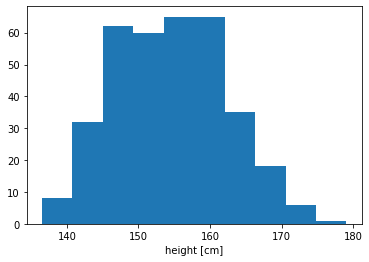

In [182]:
d2 = howell_df[howell_df["age"] >= 18]
plt.hist(d2["height"])
plt.xlabel("height [cm]")
plt.show()

### Code 4.12/4.13
Plot the priors for our height model,
$$
h_i \sim \text{Normal}(\mu, \sigma) \\
\mu \sim \text{Normal}(178, 20) \\
\sigma \sim \text{Uniform}(0, 50)
$$

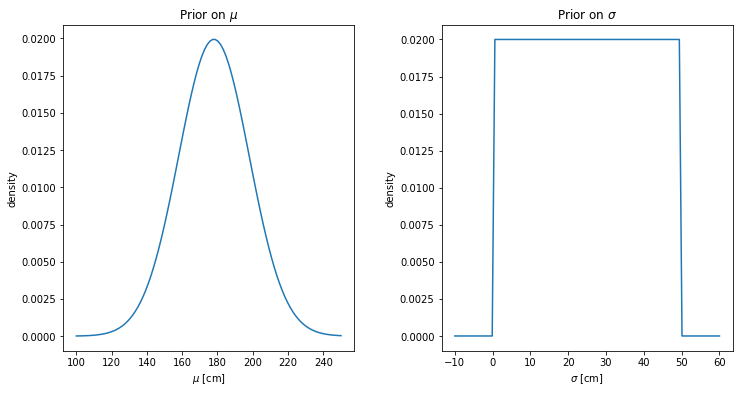

In [190]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
# mu prior
plt.sca(axes[0])
x = torch.linspace(100, 250)
y = Normal(178, 20).log_prob(x).exp()
plt.plot(x, y)
plt.title("Prior on $\mu$")
plt.xlabel("$\mu$ [cm]")
plt.ylabel("density")
# sigma prior
plt.sca(axes[1])
x = torch.linspace(-10, 60)
y = Uniform(0, 50).log_prob(x).exp()
plt.plot(x, y)
plt.title("Prior on $\sigma$")
plt.xlabel("$\sigma$ [cm]")
plt.ylabel("density")
plt.subplots_adjust(wspace=0.3)
plt.show()

### Code 4.14
Sample from the prior predictive for the $h_i$

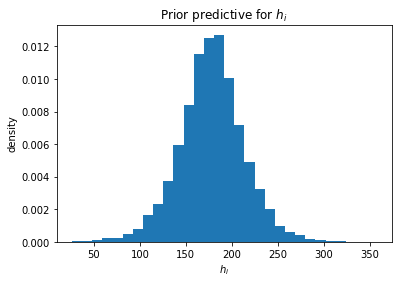

In [197]:
mu = Normal(178, 20).sample([10000])
sigma = Uniform(0, 50).sample([10000])
h = Normal(mu, sigma).sample()
plt.hist(h, bins=30, density=True)
plt.title("Prior predictive for $h_i$")
plt.xlabel("$h_i$")
plt.ylabel("density")
plt.show()

### Code 4.15
Observe the effect of a flatter prior for $\mu$ on the prior predictive for $h_i$

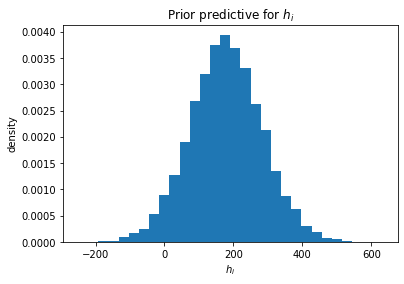

In [198]:
mu = Normal(178, 100).sample([10000])
sigma = Uniform(0, 50).sample([10000])
h = Normal(mu, sigma).sample()
plt.hist(h, bins=30, density=True)
plt.title("Prior predictive for $h_i$")
plt.xlabel("$h_i$")
plt.ylabel("density")
plt.show()

### Code 4.16
Use the grid approximation to calculate the posterior given the data

In [307]:
data = torch.tensor(d2["height"].values)
mu_grid = torch.linspace(150, 160, 100)
mu_prior = Normal(178, 20).log_prob(mu_grid).view(-1, 1)
sigma_grid = torch.linspace(7, 9, 100)
sigma_prior = Uniform(0, 50).log_prob(sigma_grid).view(1, -1)
posterior = (
    # Likelihood
    Normal(mu_grid.view(-1, 1, 1), sigma_grid.view(1, -1, 1)).log_prob(data).sum(axis=-1)
    # Priors
    + mu_prior + sigma_prior
)
posterior = torch.exp(posterior - posterior.max()) # Numerical trick to avoid overflow
posterior /= posterior.sum() # Normalize

### Code 4.17/4.18
Make a contour/heatmap plot of the posterior

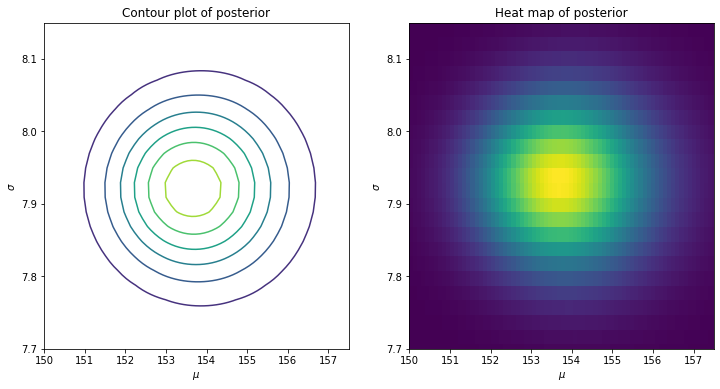

In [308]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
X, Y = np.meshgrid(mu_grid, sigma_grid)
plt.sca(axes[0])
plt.contour(X, Y, posterior)
plt.xlim(left=150, right=157.5)
plt.ylim(bottom=7.7, top=8.15)
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.title("Contour plot of posterior")
plt.sca(axes[1])
plt.pcolormesh(X, Y, posterior)
plt.xlim(left=150, right=157.5)
plt.ylim(bottom=7.7, top=8.15)
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.title("Heat map of posterior")
plt.show()

### Code 4.19/4.20
Sample from the posterior and plot the samples

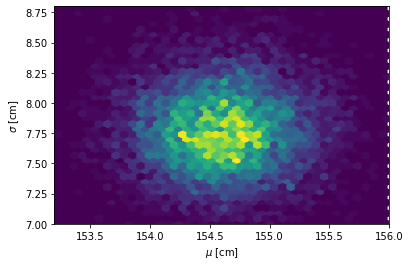

In [347]:
# The original grid was too coarse, so I'm gonna recompute on a smaller, finer grid
data = torch.tensor(d2["height"].values)
mu_grid = torch.linspace(153, 156, 500)
mu_prior = Normal(178, 20).log_prob(mu_grid).view(-1, 1)
sigma_grid = torch.linspace(7, 9, 500)
sigma_prior = Uniform(0, 50).log_prob(sigma_grid).view(1, -1)
posterior = (
    # Likelihood
    Normal(mu_grid.view(-1, 1, 1), sigma_grid.view(1, -1, 1)).log_prob(data).sum(axis=-1)
    # Priors
    + mu_prior + sigma_prior
)
posterior = torch.exp(posterior - posterior.max()) # Numerical trick to avoid overflow
posterior /= posterior.sum() # Normalize

# Sample from the posterior
idx = np.random.choice(np.prod(posterior.shape), p=posterior.flatten(), size=10000)
idx = np.vstack([idx//len(mu_grid), idx%len(mu_grid)])
samples = np.vstack((mu_grid[idx[0]], sigma_grid[idx[1]]))
plt.hexbin(*samples, gridsize=40)
# if you want to look at the scatter plot, though I don't think it's as useful:
# plt.scatter(*samples, s=0.5, alpha=0.1, color='red')
plt.xlim(left=153.2, right=156)
plt.ylim(bottom=7, top=8.8)
plt.xlabel("$\mu$ [cm]")
plt.ylabel("$\sigma$ [cm]")
plt.show()

### Code 4.21
Examine the marginal posterior densities of $\mu$ and $\sigma$

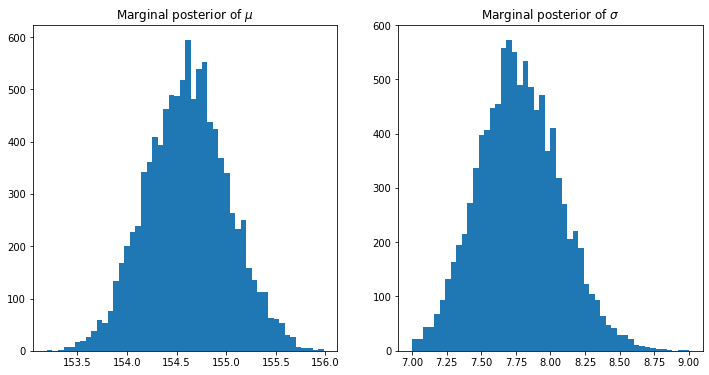

In [348]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
for i, label in enumerate(("mu", "sigma")):
    axes[i].hist(samples[i], bins=50)
    axes[i].set_title(f"Marginal posterior of $\{label}$")

### Code 4.22
Get the posterior credible intervals

In [365]:
print("mu CI:", HPDI(samples[0], 0.95))
print("sigma CI:", HPDI(samples[1], 0.95))

mu CI: (153.81163, 155.41684)
sigma CI: (7.208417, 8.35471)
